# Interest Rate Spreads
Interest rate spreads are sometimes used as a harbinger of upcoming economic slowdowns. The most widely used ones are the difference between: 1) 10-year and 2-year Treasury yields, and 2) 10-year and 3-month Treasury yields. In an economy that is expected to grow at a steady pace over 10 years, the difference is likely to be positive. In case of an impending recenssion the difference can turn negative.

Looking at just this treasury yield spread alone doesn't assuredly tell us if the inversion can be mostly attributed to an upcoming recession or to differences in inflation expectations. Lower long-term inflation expectations compared to short-term ones can also lead to an inversion in the treasury yield curve. This is because a treasury yield is made up of:

`Treasury yield = expected average future real short rate + real term premium + expected inflation + inflation risk premium`

where the `inflation risk premium` and the `real term premium` are extra compensations bond investors demand for bearing inflation risks and real interest rate risks, respectively. I.e. the risks that actual inflation and short term rates will turn out to be different from those expected. Expected average future real short rate is related to expected real GDP growth. This is why the inversion of the curve might imply a recession, i.e. when future GDP growth is less than the current one.

To arrive at a more accurate conclusion we should also take a look at the spread between different Breakeven Inflation rates (as given by subtracting the yield on the Treasury Inflation-Protected Securities of N-Year maturity from the yield on the ordinary Treasury Bond of the same N-Year maturity). A breakeven inflation rate consist of:

`Breakeven inflation rate = expected inflation + inflation risk premium`

You can read up more on this theory [here](https://www.federalreserve.gov/econres/notes/feds-notes/tips-from-tips-update-and-discussions-20190521.html).


I use the following dataseries from FRED to accomplish the task:
* `T10Y2Y` &mdash;  10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity (daily frequency)
* `T10Y3M` &mdash;  10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity (daily frequency)
* `DGS10` &mdash; Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS20` &mdash; Market Yield on U.S. Treasury Securities at 20-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `T5YIE` &mdash; 5-Year Breakeven Inflation Rate (daily frequency)
* `T10YIE` &mdash; 10-Year Breakeven Inflation Rate (daily frequency)

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail

# Install the latest version of pandas datareader
#!pip install pandas-datareader -U

In [2]:
from datetime import date

import pandas_datareader.data as web
import pandas as pd
import matplotlib.ticker as mtick

In [3]:
report_start = date.fromisoformat('2020-01-01')
report_end = date.today()

### Retrieving Daily Treasury Yields and Breakeven Inflation Rates
Unfortunately FRED doesn't publish data for 2-year Breakeven inflation rates. Therefore I resort to looking at the differences between 5-year and 10-year treasury yields and breakeven inflation rates instead.

In [4]:
# Constructing the riskless yield curve based on the current fed funds rate and treasury yields
data = web.get_data_fred(['DGS5', 'DGS10', 'T5YIE', 'T10YIE', 'T10Y2Y', 'T10Y3M'], report_start, report_end) / 100.
data.dropna(inplace=True)

# Converting all CMT Yields to APY
data = (data/2 + 1)**2 - 1

In [5]:
data['10y Tr. Yield - 5y Tr. Yield'] = data.DGS10 - data.DGS5
data['10y Breakeven Infl. Rate - 5y Breakeven Infl. Rate'] = data.T10YIE - data.T5YIE
data.rename(columns={'T10Y2Y': '10y Tr. Yield - 2y Tr. Yield',
                     'T10Y3M': '10y Tr. Yield - 3m Tr. Yield'}, inplace=True)

In [6]:
# Get rid of columns no longer required
data.drop(columns=data.columns[0:4], inplace=True)

# Rearrange columns
data = data.iloc[:, [2, 3, 0, 1]]

### Visualising the spreads

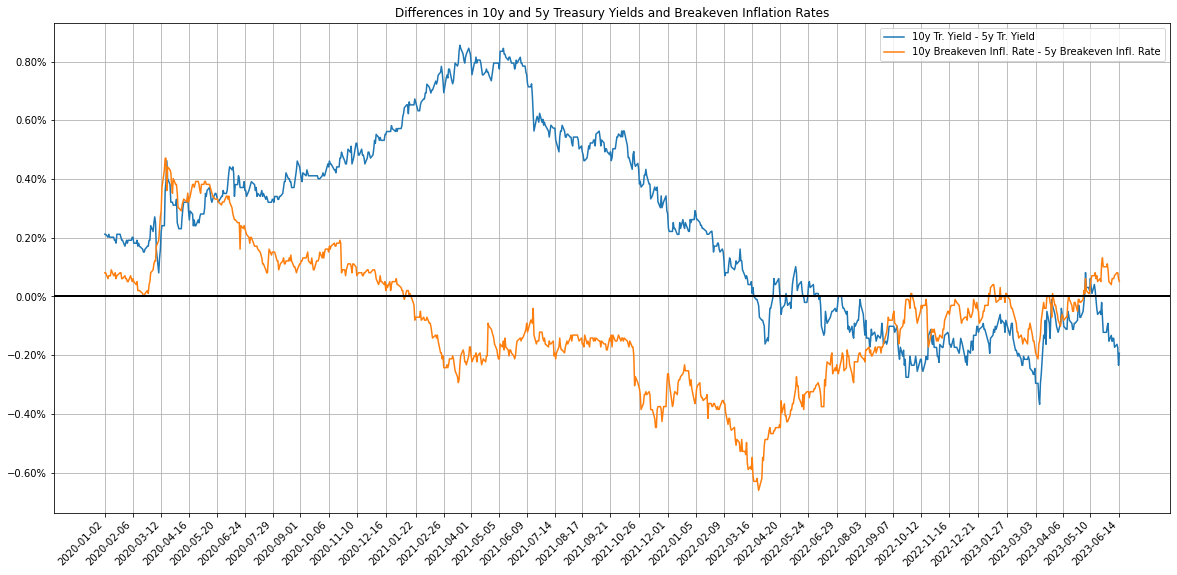

In [7]:
ax = data.iloc[:,:2].plot(figsize=(20,10), grid=True,
               title='Differences in 10y and 5y Treasury Yields and Breakeven Inflation Rates',
               xticks=data.index[::24], xlabel='', rot=45)
ax.axhline(y=0, lw=2, c='k')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

What can we conclude? The yield curve inversion (between 10-year and 5-year treasury yields) that started to show up from April 2022 was mostly brought about by growing expectations that average 10-year inflation will be less than the average inflation in the coming 5 years.

Let's now visualise the same data but with a spread between 10-year and 2-year treasury yields added.

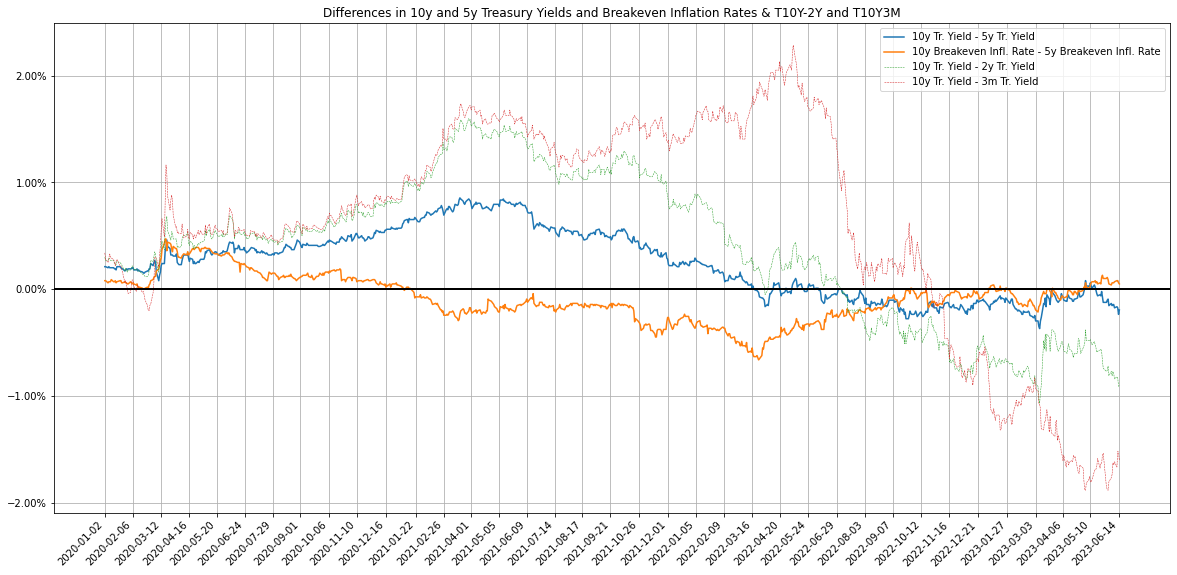

In [8]:
ax = data.iloc[:,:2].plot(figsize=(20,10), grid=True,
               title='Differences in 10y and 5y Treasury Yields and Breakeven Inflation Rates & T10Y-2Y and T10Y3M',
               xticks=data.index[::24], xlabel='', rot=45)
data.iloc[:,2:].plot(ax=ax, grid=True, xticks=data.index[::24], xlabel='', rot=45, linestyle='--', linewidth=.5)
ax.axhline(y=0, lw=2, c='k')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

And finally, let's visualize the: 1) 10-Year Treasury Yield - 2-Year Treasury Yield, and 2) 10-Year Treasury Yield - 3-Month Treasury Yield spreads:

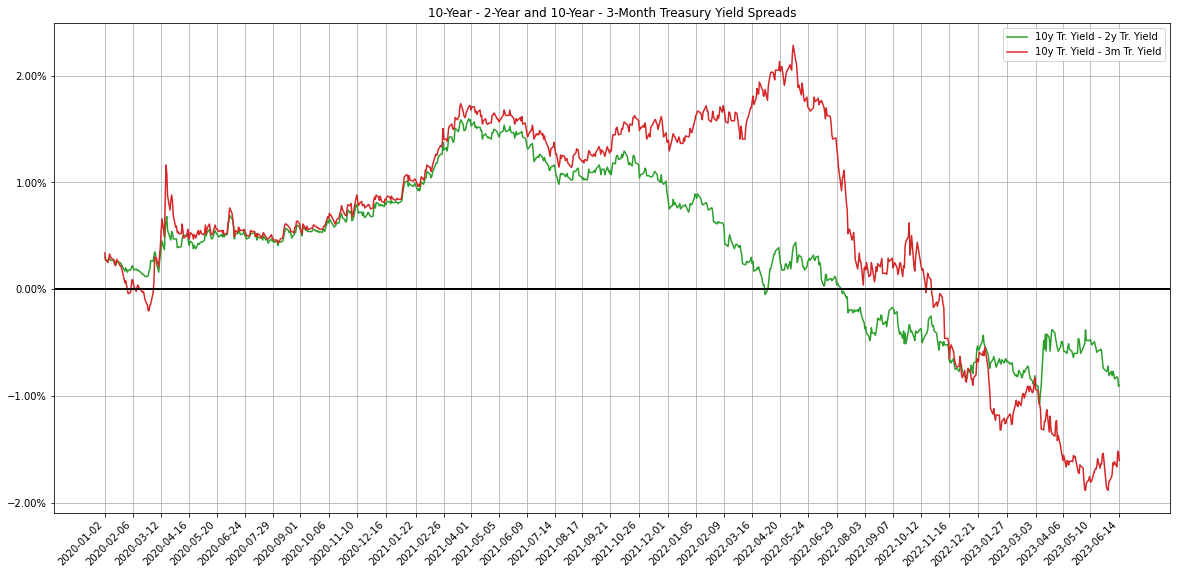

In [9]:
ax = data.iloc[:,2:].plot(figsize=(20,10), grid=True,
               title='10-Year - 2-Year and 10-Year - 3-Month Treasury Yield Spreads', color=['#2ca02c', '#d62728'],
               xticks=data.index[::24], xlabel='', rot=45)
ax.axhline(y=0, lw=2, c='k')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))